<a href="https://colab.research.google.com/github/ahmtox/stereo-matching/blob/main/ES143_Final_Deliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [1]:
%%capture
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  print('Running on Colab... Preparing to mount Google Drive')
  from google.colab import drive
  drive.mount('/content/drive')

  !apt-get install git
  !pip install pupil-apriltags
  !git clone https://github.com/ahmtox/stereo-matching.git
  !pip install boto3

  sys.path.append('/content/stereo-matching')

  print('Google Drive mounted at /content/drive')
else:
  print('Not running on Google Colab.')


In [2]:
import boto3
import botocore
import numpy as np
import matplotlib.pyplot as plt
import cv2
from camera_calibration import CameraCalibration
from stereogram_generator import StereogramGenerator
from stereo_calibration import stereo_calibrate
import torch
from model.raft_stereo import RAFTStereo

# Dataset Capture and Load

In [3]:
session = boto3.Session()

s3 = session.client('s3', config=boto3.session.Config(signature_version=botocore.UNSIGNED))

def download_files(bucket_name, local_directory):
    if not os.path.exists(local_directory):
        os.makedirs(local_directory)

    response = s3.list_objects_v2(Bucket=bucket_name)

    while True:
        for item in response.get('Contents', []):
            key = item['Key']
            local_file_path = os.path.join(local_directory, key)

            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

            s3.download_file(bucket_name, key, local_file_path)
            print(f"Downloaded {key} to {local_file_path}")

        if response['IsTruncated']:
            response = s3.list_objects_v2(Bucket=bucket_name, ContinuationToken=response['NextContinuationToken'])
        else:
            break

bucket_name = 'es143-stereo-matching'
local_directory = './'

download_files(bucket_name, local_directory)

Downloaded camera_left_final/IMG_3625.jpeg to ./camera_left_final/IMG_3625.jpeg
Downloaded camera_left_final/IMG_3626.jpeg to ./camera_left_final/IMG_3626.jpeg
Downloaded camera_left_final/IMG_3627.jpeg to ./camera_left_final/IMG_3627.jpeg
Downloaded camera_left_final/IMG_3628.jpeg to ./camera_left_final/IMG_3628.jpeg
Downloaded camera_left_final/IMG_3629.jpeg to ./camera_left_final/IMG_3629.jpeg
Downloaded camera_left_final/IMG_3630.jpeg to ./camera_left_final/IMG_3630.jpeg
Downloaded camera_left_final/IMG_3631.jpeg to ./camera_left_final/IMG_3631.jpeg
Downloaded camera_left_final/IMG_3632.jpeg to ./camera_left_final/IMG_3632.jpeg
Downloaded camera_left_final/IMG_3633.jpeg to ./camera_left_final/IMG_3633.jpeg
Downloaded camera_left_final/calibration/calibration_001.jpeg to ./camera_left_final/calibration/calibration_001.jpeg
Downloaded camera_left_final/calibration/calibration_002.jpeg to ./camera_left_final/calibration/calibration_002.jpeg
Downloaded camera_left_final/calibration/cal

In [4]:
imgL_path = './camera_left_final/IMG_3625.jpeg'
imgR_path = './camera_right_final/IMG_4206.jpeg'
calib_left_camera_filepath = './camera_left_final/calibration/calibration_*.jpeg'
calib_right_camera_filepath = './camera_right_final/calibration/calibration_*.jpeg'

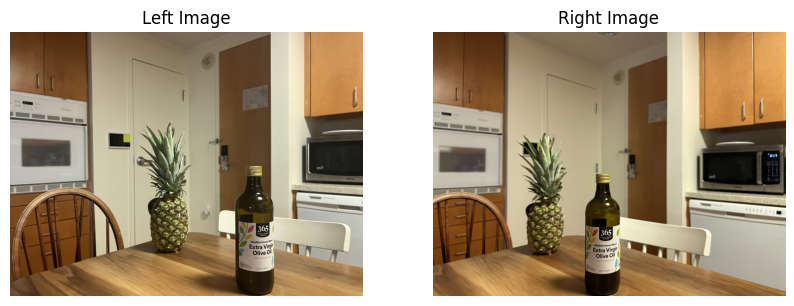

In [5]:
imgL = cv2.imread(imgL_path)
imgR = cv2.imread(imgR_path)

imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL)
ax[0].set_title('Left Image')
ax[0].axis('off')


ax[1].imshow(imgR)
ax[1].set_title('Right Image')
ax[1].axis('off')

plt.show()

# Camera Calibration

27 images:
RMSE of reprojected points: 0.6439761170943135
Distortion coefficients: [[ 0.06614 -0.27729 -0.00199  0.00039  0.41336]]
Intrinsic camera matrix:
 [[3097.94    0.   1991.97]
 [   0.   3101.79 1504.62]
 [   0.      0.      1.  ]]
Total images used for calibration:  27
Extrinsic matrix for image 1:
[[ 0.03  1.   -0.04 -0.71]
 [ 1.   -0.03  0.05 -4.51]
 [ 0.05 -0.05 -1.   18.31]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 2:
[[ 0.    1.   -0.08 -0.42]
 [ 0.94 -0.03 -0.35 -4.38]
 [-0.35 -0.07 -0.93 20.61]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 3:
[[ 0.06  1.   -0.04 -0.32]
 [ 0.84 -0.03  0.54 -3.68]
 [ 0.54 -0.07 -0.84 17.03]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 4:
[[-0.16  0.84 -0.51  1.13]
 [ 0.99  0.11 -0.13 -5.48]
 [-0.05 -0.52 -0.85 22.52]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 5:
[[ 0.14  0.99  0.06 -2.12]
 [ 0.93 -0.11 -0.35 -3.76]
 [-0.34  0.1  -0.94 21.51]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image

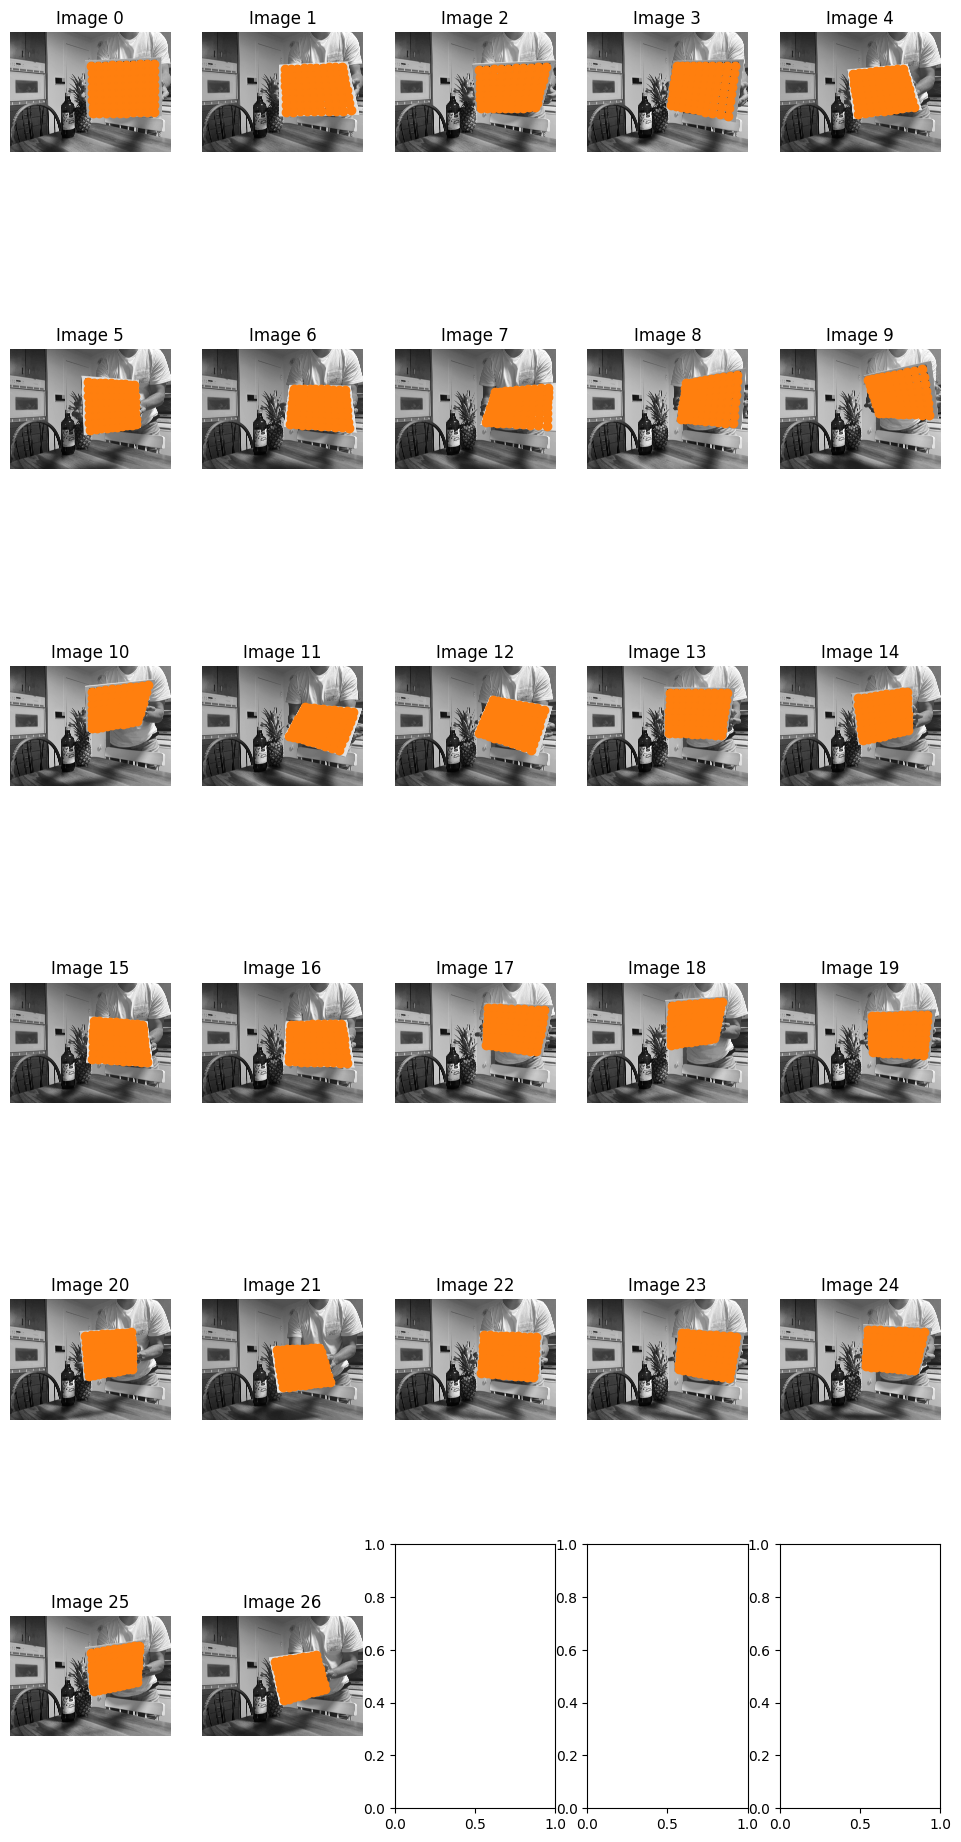

In [6]:
left_cc = CameraCalibration()
reprojerr_L, calMatrix_L, distCoeffs_L, calRotations_L, calTranslations_L, extrinsic_matrices_L, calObjPoints_L, calImgPoints_L = left_cc.calibrate_camera(calib_left_camera_filepath, True)

27 images:
RMSE of reprojected points: 0.35510101349302564
Distortion coefficients: [[ 0.14588  0.14601  0.00246  0.00174 -2.16759]]
Intrinsic camera matrix:
 [[2841.83    0.   2031.05]
 [   0.   2843.48 1535.45]
 [   0.      0.      1.  ]]
Total images used for calibration:  27
Extrinsic matrix for image 1:
[[ 0.02  1.   -0.04 -7.56]
 [ 1.   -0.02  0.03 -4.2 ]
 [ 0.03 -0.04 -1.   18.22]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 2:
[[-0.01  1.   -0.07 -7.3 ]
 [ 0.93 -0.02 -0.37 -4.03]
 [-0.37 -0.07 -0.93 20.54]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 3:
[[ 0.05  1.   -0.05 -7.18]
 [ 0.85 -0.02  0.52 -3.4 ]
 [ 0.52 -0.07 -0.85 16.95]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 4:
[[-0.17  0.85 -0.51 -5.73]
 [ 0.98  0.11 -0.15 -5.07]
 [-0.07 -0.52 -0.85 22.48]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for image 5:
[[ 0.13  0.99  0.07 -9.  ]
 [ 0.93 -0.09 -0.36 -3.42]
 [-0.35  0.11 -0.93 21.41]
 [ 0.    0.    0.    1.  ]]
Extrinsic matrix for imag

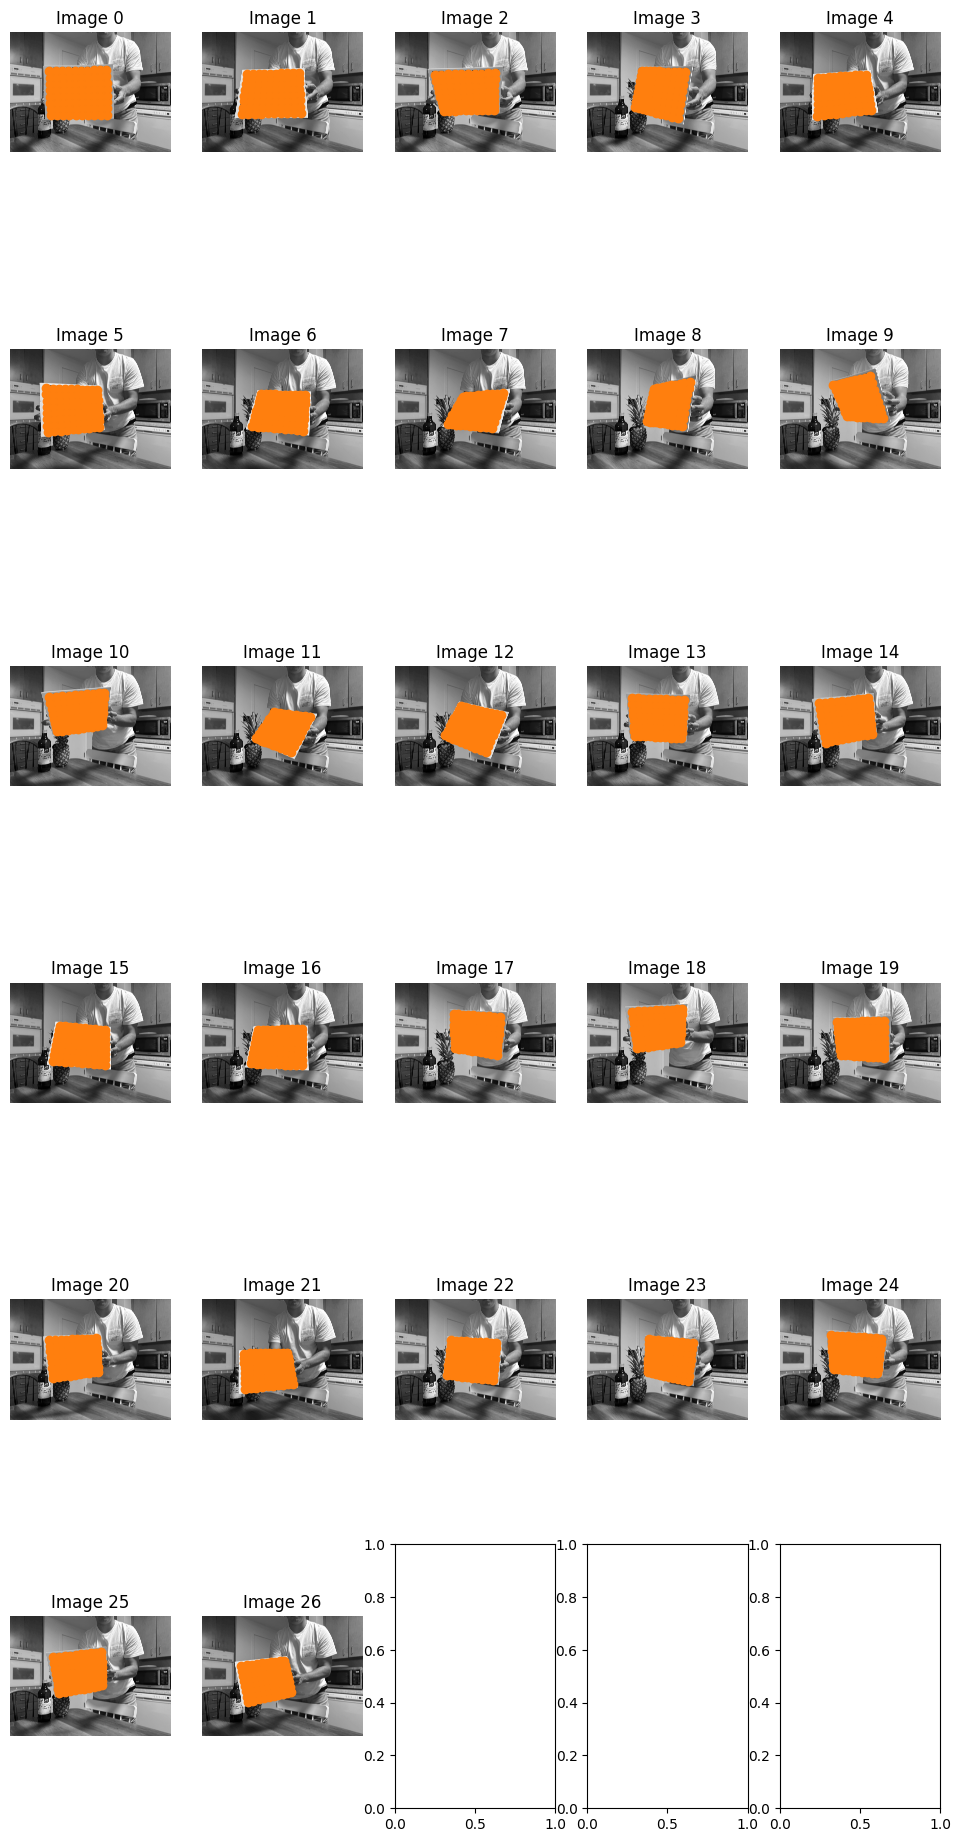

In [7]:
right_cc = CameraCalibration()
reprojerr_R, calMatrix_R, distCoeffs_R, calRotations_R, calTranslations_R, extrinsic_matrices_R, calObjPoints_R, calImgPoints_R = right_cc.calibrate_camera(calib_right_camera_filepath, True)

In [8]:
print("Number of object point sets:", len(calObjPoints_L))
print("Number of image point sets in left images:", len(calImgPoints_L))
print("Number of image point sets in right images:", len(calImgPoints_R))

print("Object points per set:", [len(pts) for pts in calObjPoints_L])
print("Image points in left per set:", [len(pts) for pts in calImgPoints_L])
print("Image points in right per set:", [len(pts) for pts in calImgPoints_R])


Number of object point sets: 27
Number of image point sets in left images: 27
Number of image point sets in right images: 27
Object points per set: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Image points in left per set: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Image points in right per set: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


# Stereo Rectification

## Stereo Rectification Using OpenCV

In [9]:
img_shape = (imgR.shape[0], imgR.shape[1])

flags = cv2.CALIB_RATIONAL_MODEL
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-5)
retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(
        calObjPoints_L, calImgPoints_L, calImgPoints_R, calMatrix_L, distCoeffs_L, calMatrix_R, distCoeffs_R, img_shape,
        criteria=criteria, flags=flags)

In [10]:
print('R:\n', R, '\n')
print('T:\n', T, '\n')
print('E:\n', E, '\n')
print('F:\n', F, '\n')


R:
 [[ 1.   -0.01 -0.  ]
 [ 0.01  1.    0.02]
 [ 0.   -0.02  1.  ]] 

T:
 [[-6.93]
 [-0.08]
 [ 0.02]] 

E:
 [[-0.   -0.02 -0.09]
 [ 0.03 -0.14  6.93]
 [ 0.   -6.93 -0.14]] 

F:
 [[ 0.    0.    0.  ]
 [-0.    0.   -0.01]
 [ 0.    0.    1.  ]] 



In [11]:
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imgR.shape[:2], R, T)

map1x, map1y = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imgL.shape[:2], cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imgR.shape[:2], cv2.CV_32FC1)

rectified_imgL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
rectified_imgR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)


### Stereo Rectification Visualization




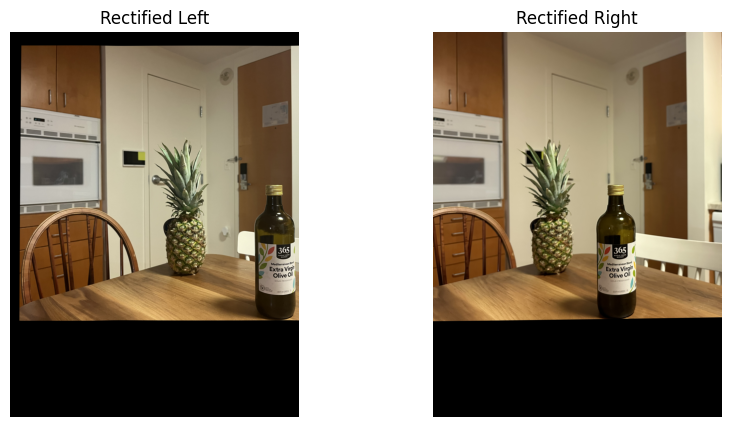

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rectified_imgL)
ax[0].set_title('Rectified Left')
ax[0].axis('off')

ax[1].imshow(rectified_imgR)
ax[1].set_title('Rectified Right')
ax[1].axis('off')

plt.show()

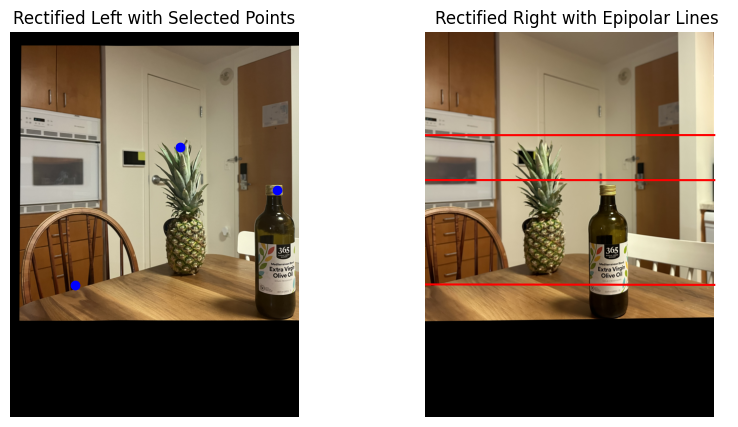

In [13]:
def plot_epipolar_lines(image, epilines, ax, color='r'):
    height, width = image.shape[:2]


    for r in epilines:
        x0, y0 = 0, int(-r[2] / r[1])
        x1, y1 = width, int(-(r[2] + r[0] * width) / r[1])

        ax.plot([x0, x1], [y0, y1], color)


points_left = np.array([
    [2800, 1650],
    [680, 2650],
    [1780, 1200],
], dtype=np.float32)

points_left_hom = np.hstack([points_left, np.ones((points_left.shape[0], 1))])

epilines_right = cv2.computeCorrespondEpilines(points_left_hom, 2, F).reshape(-1, 3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rectified_imgL)
ax[0].scatter(points_left[:, 0], points_left[:, 1], c='b', marker='o')
ax[0].set_title('Rectified Left with Selected Points')
ax[0].axis('off')

ax[1].imshow(rectified_imgR)
plot_epipolar_lines(rectified_imgR, epilines_right, ax[1])
ax[1].set_title('Rectified Right with Epipolar Lines')
ax[1].axis('off')

plt.show()

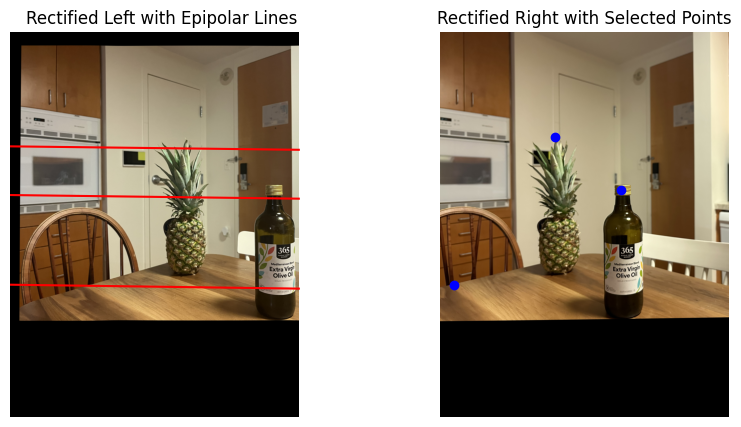

In [14]:
points_right = np.array([
    [1900, 1650],
    [150, 2650],
    [1200, 1100],
], dtype=np.float32)

points_right_hom = np.hstack([points_right, np.ones((points_right.shape[0], 1))])

epilines_left = cv2.computeCorrespondEpilines(points_right_hom, 1, F).reshape(-1, 3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rectified_imgL)
plot_epipolar_lines(rectified_imgL, epilines_left, ax[0])
ax[0].set_title('Rectified Left with Epipolar Lines')
ax[0].axis('off')

ax[1].imshow(rectified_imgR)
ax[1].scatter(points_right[:, 0], points_right[:, 1], c='b', marker='o')
ax[1].set_title('Rectified Right with Selected Points')
ax[1].axis('off')

plt.show()

## Stereo Rectification Using Direct Stereo Rectification

Module rectification taken from DirectStereoRectification GitHub Repository.

Available at: https://github.com/decadenza/DirectStereoRectification

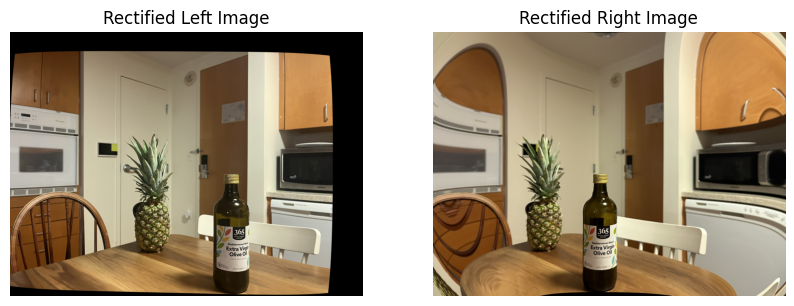

In [15]:
from rectification import *

dims1 = imgL.shape[::-1][1:]
dims2 = imgR.shape[::-1][1:]

A1 = calMatrix_L.copy()
A2 = calMatrix_R.copy()

RT1 = extrinsic_matrices_L[0][:3, :]
RT2 = extrinsic_matrices_R[0][:3, :]

distCoeffs1 = distCoeffs_L.copy()
distCoeffs2 = distCoeffs_R.copy()

Po1 = A1.dot(RT1)
Po2 = A2.dot(RT2)

F = getFundamentalMatrixFromProjections(Po1, Po2)

Rectify1, Rectify2 = getDirectRectifications(A1, A2, RT1, RT2, dims1, dims2, F)

destDims = dims1

Fit = getFittingMatrix(A1, A2, Rectify1, Rectify2, dims1, dims2, distCoeffs1, distCoeffs2)

mapx1, mapy1 = cv2.initUndistortRectifyMap(A1, distCoeffs1, Rectify1.dot(A1), Fit, destDims, cv2.CV_32FC1)
mapx2, mapy2 = cv2.initUndistortRectifyMap(A2, distCoeffs2, Rectify2.dot(A2), Fit, destDims, cv2.CV_32FC1)

img1_rect = cv2.remap(imgL, mapx1, mapy1, interpolation=cv2.INTER_LINEAR);
img2_rect = cv2.remap(imgR, mapx2, mapy2, interpolation=cv2.INTER_LINEAR);


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img1_rect)
ax[0].set_title('Rectified Left Image')
ax[0].axis('off')

ax[1].imshow(img2_rect)
ax[1].set_title('Rectified Right Image')
ax[1].axis('off')

plt.show()


### Stereo Rectification Visualization


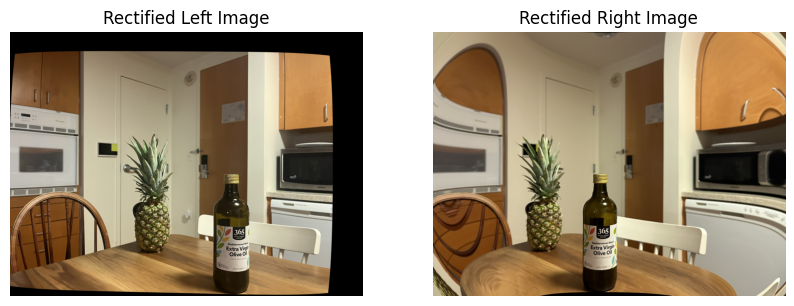

In [16]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img1_rect)
ax[0].set_title('Rectified Left Image')
ax[0].axis('off')

ax[1].imshow(img2_rect)
ax[1].set_title('Rectified Right Image')
ax[1].axis('off')

plt.show()

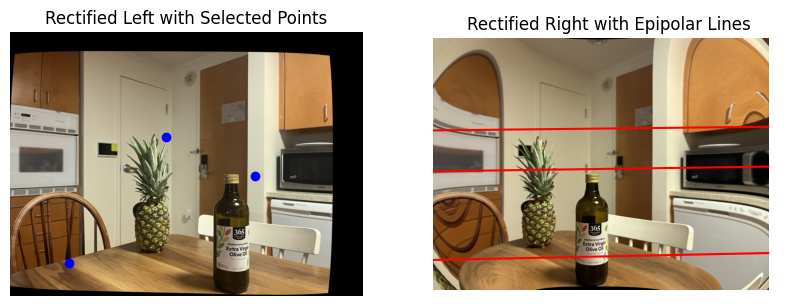

In [17]:
def plot_epipolar_lines(image, epilines, ax, color='r'):
    height, width = image.shape[:2]


    for r in epilines:
        x0, y0 = 0, int(-r[2] / r[1])
        x1, y1 = width, int(-(r[2] + r[0] * width) / r[1])

        ax.plot([x0, x1], [y0, y1], color)


points_left = np.array([
    [2800, 1650],
    [680, 2650],
    [1780, 1200],
], dtype=np.float32)

points_left_hom = np.hstack([points_left, np.ones((points_left.shape[0], 1))])

epilines_right = cv2.computeCorrespondEpilines(points_left_hom, 2, F).reshape(-1, 3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img1_rect)
ax[0].scatter(points_left[:, 0], points_left[:, 1], c='b', marker='o')
ax[0].set_title('Rectified Left with Selected Points')
ax[0].axis('off')

ax[1].imshow(img2_rect)
plot_epipolar_lines(img2_rect, epilines_right, ax[1])
ax[1].set_title('Rectified Right with Epipolar Lines')
ax[1].axis('off')

plt.show()

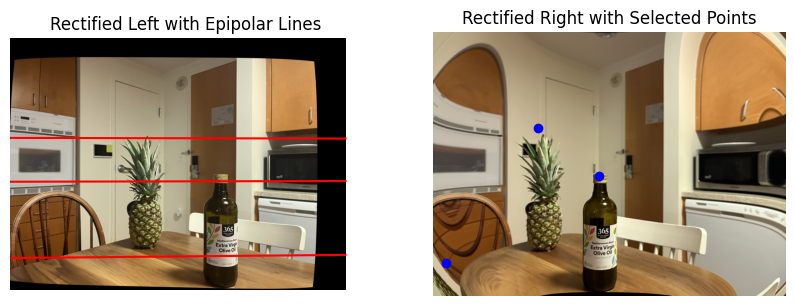

In [18]:
points_right = np.array([
    [1900, 1650],
    [150, 2650],
    [1200, 1100],
], dtype=np.float32)

points_right_hom = np.hstack([points_right, np.ones((points_right.shape[0], 1))])

epilines_left = cv2.computeCorrespondEpilines(points_right_hom, 1, F).reshape(-1, 3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img1_rect)
plot_epipolar_lines(img1_rect, epilines_left, ax[0])
ax[0].set_title('Rectified Left with Epipolar Lines')
ax[0].axis('off')

ax[1].imshow(img2_rect)
ax[1].scatter(points_right[:, 0], points_right[:, 1], c='b', marker='o')
ax[1].set_title('Rectified Right with Selected Points')
ax[1].axis('off')

plt.show()

## Uncalibrated Stereo Rectification using through keypoint matching using SIFT, FLANN Matcher and RANSAC

In [ ]:
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(imgL_gray, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR_gray, None)

flann_index_params = dict(algorithm=0, trees=5)
flann_search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(flann_index_params, flann_search_params)
matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

good_matches = []
matches_mask = [[0, 0] for i in range(len(matches))]
for i, (m, n) in enumerate(matches):
  if m.distance < 0.75 * n.distance:
      good_matches.append(m)
      matches_mask[i] = [1, 0]

img_kp_left = cv2.drawKeypoints(imgL_gray, keypoints_left, None)
img_kp_right = cv2.drawKeypoints(imgR_gray, keypoints_right, None)
img_matches = cv2.drawMatches(imgL_gray, keypoints_left, imgR_gray, keypoints_right, good_matches, None)

src_pts = np.float32([keypoints_left[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_right[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

F, _ = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 3.0, 0.99)

retval, rectification_left, rectification_right = cv2.stereoRectifyUncalibrated(
  src_pts, dst_pts, F, imgL_gray.shape[::-1])

rectification_left = rectification_left.astype(np.float32)
rectification_right = rectification_right.astype(np.float32)

rectified_img_left = cv2.warpPerspective(imgL, rectification_left, imgL_gray.shape[::-1])
rectified_img_right = cv2.warpPerspective(imgR, rectification_right, imgR_gray.shape[::-1])



### Stereo Rectification Visualizations

In [ ]:
if IN_COLAB:
    from google.colab.patches import cv2_imshow

imgSift = cv2.drawKeypoints(
    imgL_gray, keypoints_left, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

if IN_COLAB:
    cv2_imshow(imgSift)

In [ ]:
imgSift = cv2.drawKeypoints(
    imgR_gray, keypoints_right, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

if IN_COLAB:
    cv2_imshow(imgSift)

In [ ]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matches_mask,
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    imgL_gray, keypoints_left, imgR_gray, keypoints_right, matches, None, **draw_params)

if IN_COLAB:
    cv2_imshow(keypoint_matches)

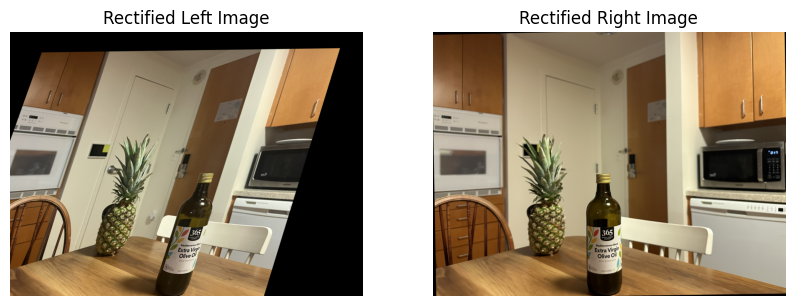

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Rectified Left Image')
plt.imshow(rectified_img_left)
plt.axis('off')
plt.subplot(122)
plt.title('Rectified Right Image')
plt.imshow(rectified_img_right)
plt.axis('off')
plt.show()

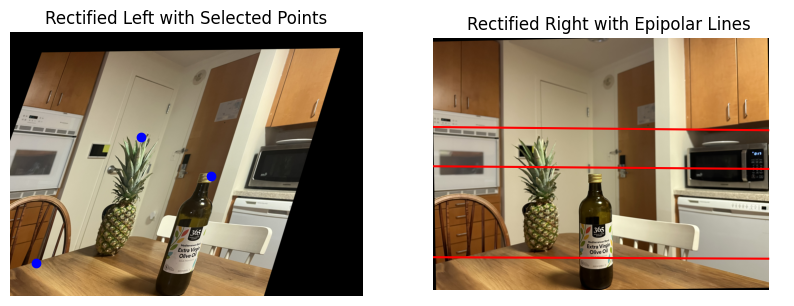

In [ ]:
def plot_epipolar_lines(image, epilines, ax, color='r'):
    height, width = image.shape[:2]


    for r in epilines:
        x0, y0 = 0, int(-r[2] / r[1])
        x1, y1 = width, int(-(r[2] + r[0] * width) / r[1])

        ax.plot([x0, x1], [y0, y1], color)


points_left = np.array([
    [2300, 1650],
    [300, 2650],
    [1500, 1200],
], dtype=np.float32)

points_left_hom = np.hstack([points_left, np.ones((points_left.shape[0], 1))])

epilines_right = cv2.computeCorrespondEpilines(points_left_hom, 2, F).reshape(-1, 3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rectified_img_left)
ax[0].scatter(points_left[:, 0], points_left[:, 1], c='b', marker='o')
ax[0].set_title('Rectified Left with Selected Points')
ax[0].axis('off')

ax[1].imshow(rectified_img_right)
plot_epipolar_lines(rectified_img_right, epilines_right, ax[1])
ax[1].set_title('Rectified Right with Epipolar Lines')
ax[1].axis('off')

plt.show()

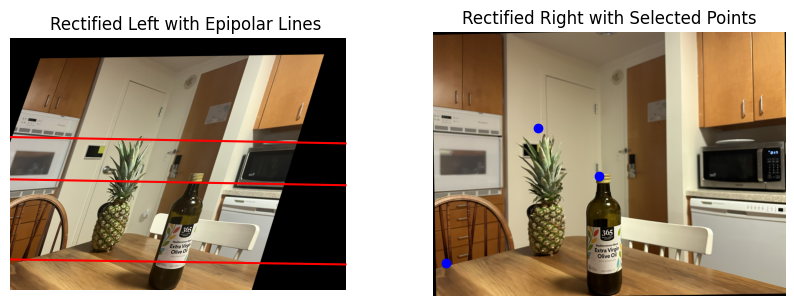

In [ ]:
points_right = np.array([
    [1900, 1650],
    [150, 2650],
    [1200, 1100],
], dtype=np.float32)

points_right_hom = np.hstack([points_right, np.ones((points_right.shape[0], 1))])

epilines_left = cv2.computeCorrespondEpilines(points_right_hom, 1, F).reshape(-1, 3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rectified_img_left)
plot_epipolar_lines(rectified_img_left, epilines_left, ax[0])
ax[0].set_title('Rectified Left with Epipolar Lines')
ax[0].axis('off')

ax[1].imshow(rectified_img_right)
ax[1].scatter(points_right[:, 0], points_right[:, 1], c='b', marker='o')
ax[1].set_title('Rectified Right with Selected Points')
ax[1].axis('off')

plt.show()

# Winner-take-all Part 1

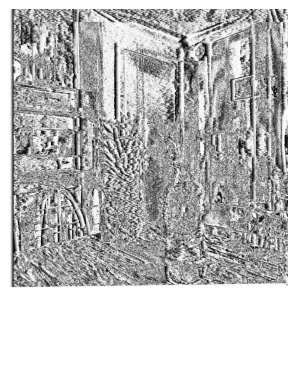

In [ ]:
import abc

# Define class with the cost_volume array
class MatchingAlgorithm(abc.ABC):
    @staticmethod
    @abc.abstractmethod
    def match(cost_volume: np.ndarray) -> np.ndarray:
        if cost_volume.ndim != 3:
            raise ValueError("Cost volume (" + str(cost_volume.shape) + ") must be three-dimensional")
        pass

# Define WinnerTakeAll to find the minimum disparity
class WinnerTakeAll(MatchingAlgorithm):
    @staticmethod
    def match(cost_volume: np.ndarray) -> np.ndarray:
        if cost_volume.ndim != 3:
            raise ValueError("Cost volume must be three-dimensional")
        return np.argmin(cost_volume, axis=2) # Returns minimum disparity

def compute_ssd_cost_volume(img_left, img_right, max_disparity, window_size):
    # Convert images to grayscale first
    if len(img_left.shape) > 2:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    if len(img_right.shape) > 2:
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    height, width = img_left.shape
    cost_volume = np.zeros((height, width, max_disparity))

    # Compute SSD for each disparity
    for d in range(max_disparity):
        img_shifted = np.roll(img_right, -d, axis=1)
        squared_differences = (img_left[:, d:] - img_shifted[:, d:]) ** 2
        # Apply windowed sum using convolution with uniform filter
        cost_volume[:, d:, d] = cv2.boxFilter(squared_differences, ddepth=-1, ksize=(window_size, window_size))
    return cost_volume

# Set parameters
max_disparity = 40
window_size = 5

# Compute SSD cost volume
cost_volume = compute_ssd_cost_volume(rectified_imgL, rectified_imgR, max_disparity, window_size)

# Compute and display grayscale disparity map using WTA
disparity_map = WinnerTakeAll.match(cost_volume)
plt.axis('off')
plt.imshow(disparity_map, cmap = 'Greys')

# Winner-take-all Part 2

100%|██████████| 998/998 [02:29<00:00,  6.68it/s]


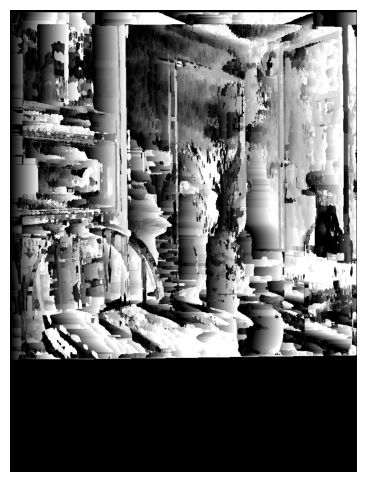

In [ ]:
from tqdm import tqdm

# Define Winner-Take-All with Sum of Absolute Differences
def winner_take_all_sad(left_img, right_img, window_height, window_width, max_disparity):

    # Define disparity map
    height, width = left_img.shape[0], left_img.shape[1]
    disparity_map = np.zeros((height, width), dtype=np.uint8)

    half_window_height = window_height // 2
    half_window_width = window_width // 2

    # Iterate through each pixel in the image to generate patches
    for y in tqdm(range(half_window_height, height - half_window_height)):
        for x in range(half_window_width, width - half_window_width):
            min_sad = float('inf')
            best_disparity = 0

            # Discover the best disparity for the current pixel
            for d in range(max_disparity):
                if x - d >= half_window_width:
                    # Generate the left and right windows
                    left_window = left_img[y - half_window_height:y + half_window_height + 1, x - half_window_width:x + half_window_width + 1]
                    right_window = right_img[y - half_window_height:y + half_window_height + 1, x - d - half_window_width:x - d + half_window_width + 1]

                    # Compute the sum of absolute differences and update the best disparity
                    sad = np.sum(np.abs(left_window - right_window))

                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d

            disparity_map[y, x] = best_disparity

    return disparity_map

# Set the downsampling ratio for the images
downsampling_ratio = .25

resized_imgL = cv2.resize(
    rectified_imgL,
    (int(rectified_imgL.shape[1]*downsampling_ratio), int(rectified_imgL.shape[0]*downsampling_ratio)),
    interpolation=cv2.INTER_AREA
)
resized_imgR = cv2.resize(
    rectified_imgR,
    (int(rectified_imgR.shape[1]*downsampling_ratio), int(rectified_imgR.shape[0]*downsampling_ratio)),
    interpolation=cv2.INTER_AREA
)

# Set the window height, window width, and maximum disparity range
window_height = 10
window_width = 3
max_disparity = 64

# Compute the disparity map using the winner-take-all algorithm with SAD
disparity_map = winner_take_all_sad(resized_imgL, resized_imgR, window_height, window_width, max_disparity)

# Display the disparity map
plt.figure(figsize=(8, 6))
plt.imshow(disparity_map, cmap='gray')
plt.axis('off')
plt.show()

# Dynamic Programming

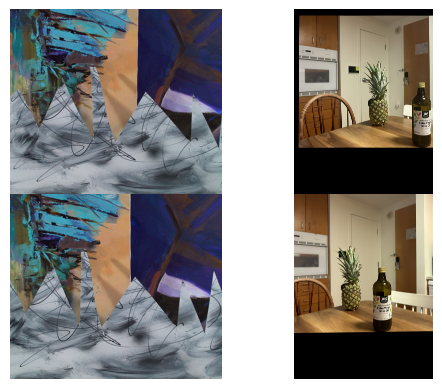

In [19]:
# TEST IMAGES: PERFECTLY STEREO RECTIFIED
imgL_path = './left.jpeg'
imgR_path = './right.jpeg'

left_test = cv2.imread(imgL_path)
right_test = cv2.imread(imgR_path)

ax1 = plt.subplot(2,2,1)
plt.imshow(left_test)
ax1.axis('off')
ax2 = plt.subplot(2,2,3)
plt.imshow(right_test)
ax2.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

# OUR IMAGES
captureL = rectified_imgL
captureR = rectified_imgR

ax3 = plt.subplot(2,2,2)
plt.imshow(captureL)
ax3.axis('off')
ax4 = plt.subplot(2,2,4)
plt.imshow(captureR)
ax4.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

In [20]:
#@title Compute Cost Matrix

def compute_cost(leftScan, rightScan, max_disparity=32):
    lenL = len(leftScan)
    lenR = len(rightScan)

    # Initialize the cost matrix with infinity
    C = np.full((lenL, max_disparity), float('inf'))

    # Populate the cost matrix
    for i in range(0, lenL):
      for j in range(0, max_disparity):
        # print(i, j)
        C[i, j] = abs(int(leftScan[i]) - int(rightScan[min(i + j, lenR - 1)]))

    return C

In [21]:
#@title [UNFINISHED] Dynamic Programming

def best_dynamic_programming(cost_matrix, jump_cost=1):
    pixels = cost_matrix.shape[0]
    disparities = cost_matrix.shape[1]

    arr_best_k = np.full_like(cost_matrix, 100)

    # Populate the cost matrix
    for i in range(1, pixels):
      for j in range(0, disparities):

        # Compute the minimum cost considering jump costs for smooth transitions
        best_prev_cost = float('inf')
        best_k = np.nan

        for k in range(0, disparities):
          jump_penalty = jump_cost * abs(j - k)
          prev_cost = cost_matrix[i, k] + jump_penalty

          if prev_cost < best_prev_cost:
            best_prev_cost = prev_cost
            best_k = k

        cost_matrix[i, j] += best_prev_cost
        arr_best_k[i, j] = int(best_k)

    # Backtrack to find the optimal path
    disparity = np.zeros(pixels, dtype=int)

    i, j = int(pixels - 1), int(np.argmin(cost_matrix[-1]))
    print("starting coordinate for backtracking:", i, j)

    arr_best_k = arr_best_k.astype(int)

    while i >= 0:
      disparity[i] = j
      j = arr_best_k[i][j]
      i -= 1

    return disparity

SHOWING RESULTS FOR 200TH ROW OF TEST IMAGES
starting coordinate for backtracking: 433 0

COST MATRIX
[[ 17.    45.     9.   ...  65.    82.   134.  ]
 [ 54.06  18.05  71.04 ...  95.23 147.24 120.25]
 [  0.    53.01  67.02 ... 125.29  98.3   90.31]
 ...
 [211.02 239.01 202.   ... 202.   202.   202.  ]
 [243.01 206.   206.   ... 206.   206.   206.  ]
 [208.   208.   208.   ... 208.   208.   208.  ]]

DISPARITY
[ 6  0  3  2  1  0 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4
 31 30 31  1  0 29 29 25 15  1 30 28 30 30 17 28 27 14 25 22 10  6  3 19
  6  5  4  3  2  0  0 31 29 28 27 27 26 24 23 22 21 20 19 18 17 16 16 14
 13 13 12 11 10  8  8  7 25 24  6  5  4  3  2  1  2  5  4  3 17 16 15 14
 13 31 31 10  9 31 30  6  5 30 25 24  1 31  5 14 23 31 30 29 28 14 23 25
 24 23 22 21 20 19 18 17 16 15 14 13 12 31 26 26 25 21 20 19 17 12  1  3
  2  0 25 24 31 30 29 29 28 28 27 26 25 24 23 22 21 20 19 31 11 22 13 11
 20 26 28 31 31  8  7 28 27 26  3  2  1  0 21 20 19 18 17 16  0 31 31 31
 31

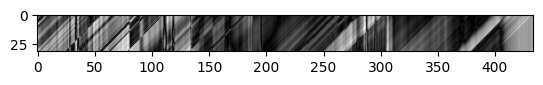

In [22]:
#@title Dynamic Programming Test

left_input = cv2.cvtColor(left_test, cv2.COLOR_BGR2GRAY)
right_input = cv2.cvtColor(right_test, cv2.COLOR_BGR2GRAY)
max_disparity = 32
occlusion_cost = 10
jump_cost = 0.01

print("SHOWING RESULTS FOR 200TH ROW OF TEST IMAGES")

cost_test = compute_cost(left_input[200], right_input[200], max_disparity = 32)
plt.imshow(cost_test.T, cmap='gray')

disp_map = np.zeros_like(left_input)
disp_map[200] = best_dynamic_programming(cost_test, jump_cost=jump_cost)

print("\nCOST MATRIX")
print(cost_test)

print("\nDISPARITY")
print(disp_map[200])

In [27]:
#@title [UNFINISHED, NO TEST OUTPUT] Dynamic Programming

def best_dynamic_programming(cost_matrix, jump_cost=1):
    pixels = cost_matrix.shape[0]
    disparities = cost_matrix.shape[1]

    arr_best_k = np.full_like(cost_matrix, 100)

    # Populate the cost matrix
    for i in range(1, pixels):
      for j in range(0, disparities):

        # Compute the minimum cost considering jump costs for smooth transitions
        best_prev_cost = float('inf')
        best_k = np.nan

        for k in range(0, disparities):
          jump_penalty = jump_cost * abs(j - k)
          prev_cost = cost_matrix[i, k] + jump_penalty

          if prev_cost < best_prev_cost:
            best_prev_cost = prev_cost
            best_k = k

        cost_matrix[i, j] += best_prev_cost
        arr_best_k[i, j] = int(best_k)

    # Backtrack to find the optimal path
    disparity = np.zeros(pixels, dtype=int)

    i, j = int(pixels - 1), int(np.argmin(cost_matrix[-1]))
    # print("starting coordinate for backtracking:", i, j)

    arr_best_k = arr_best_k.astype(int)

    while i >= 0:
      disparity[i] = j
      j = arr_best_k[i][j]
      i -= 1

    return disparity

. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 


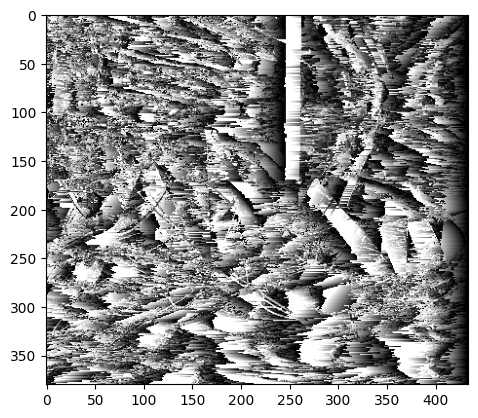

In [28]:
#@title Full Dynamic Programming Test

max_disparity = 32
occlusion_cost = 10
jump_cost = 0.01

disp_map = np.zeros_like(left_input)

for i in range(len(left_input)):
  print('.', end=' ')
  if (i + 1) % 20 == 0:
    print()

  cost_matrix = compute_cost(left_input[i], right_input[i], max_disparity=32)
  disp_map[i] = best_dynamic_programming(cost_matrix, jump_cost=jump_cost)

plt.imshow(disp_map, cmap='gray')

# Third Party Dense Stereo Matching Algorithm w/o Neural Network

(-0.5, 3023.5, 4031.5, -0.5)

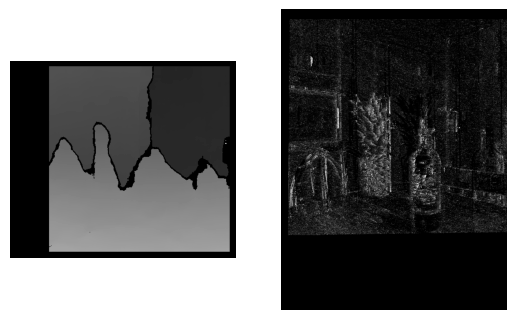

In [32]:
#@title WinnerTakesAll()

def load_images(left_img, right_img):
    # Load rectified stereo images
    left_image = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_image = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    return left_image, right_image

def compute_disparity(left_img, right_img, numDisparities=64, blockSize=15):
    # Create a stereo block matching object
    stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize) # numDisparities % 16 = 0, blockSize is odd and > 5

    # Compute initial disparity map
    disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0
    return disparity

def normalize_disparity(disparity_map):
    # Normalize disparity for visualization
    disp_norm = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disp_norm = np.uint8(disp_norm)
    return disp_norm

testL, rightR = load_images(left_test, right_test)
initial_disparity = compute_disparity(testL, rightR, numDisparities=64, blockSize=25)
norm = normalize_disparity(initial_disparity)

captureL, captureR = load_images(captureL, captureR)
initial_disparity2 = compute_disparity(captureL, captureR, numDisparities=64, blockSize=5)
norm2 = normalize_disparity(initial_disparity2)

ax1 = plt.subplot(1,2,1)
plt.imshow(norm, cmap='gray')
ax1.axis('off')
ax2 = plt.subplot(1,2,2)
plt.imshow(norm2, cmap='gray')
ax2.axis('off')

Note: the black sections of our captured images likely contributed to the poor disparity identification. Given more time, we would have rectified this. Below, we see that the identified range of disparity values for the 200th row of the test image range between 8 and 25.

In [24]:
print(initial_disparity[200])

[-1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.
 -1.   -1.   -1.   -1.   -1.   24.5  24.44 24.5  24.5  24.5  24.44 24.44
 24.44 24.38 24.38 24.38 24.38 24.38 24.38 24.31 24.31 24.31 24.31 24.31
 24.25 24.25 24.25 24.25 24.25 24.25 24.25 24.25 24.19 24.19 24.25 24.25
 24.25 24.19 24.19 24.19 24.19 24.19 24.19 24.19 24.19 24.19 24.12 24.12
 24.12 24.12 24.12 24.12 24.12 24.19 24.19 24.19 24.19 24.19 24.19 24.19
 24.25 24.25 24.25 -1.   -1.   -1.   -1.   13.69 13.69 13.69 13.69 13.69
 13.75 13.75 13.75 13.75 13.75 13.75 13.69 13.69 13.69 13.69 13.69 13.69
 -1.   -1.   -1.   -1.   -1.   -1.   -1.   23.62 23.62 23.62 23

# Third Party Dense Stereo Matching Algorithm w/ Neural Network

In [ ]:
checkpoint = torch.load('stereo-matching/model/raftstereo-middlebury.pth')

class Args:
  def __init__(self,
               hidden_dims=[128]*3,
               corr_implementation='reg',
               shared_backbone=True,
               corr_levels=4,
               corr_radius=4,
               n_downsample=2,
               context_norm='batch',
               slow_fast_gru=True,
               n_gru_layers=3,
               mixed_precision=True):

    self.hidden_dims=hidden_dims
    self.corr_implementation=corr_implementation
    self.shared_backbone=shared_backbone
    self.corr_levels=corr_levels
    self.corr_radius=corr_radius
    self.n_downsample=n_downsample
    self.context_norm=context_norm
    self.slow_fast_gru=slow_fast_gru
    self.n_gru_layers=n_gru_layers
    self.mixed_precision=mixed_precision


args = Args()
model = RAFTStereo(args)
model.cuda()
model.eval()



In [ ]:
downsampling_ratio = .25

resized_imgL = cv2.resize(
    imgL,
    (int(imgL.shape[1]*downsampling_ratio), int(imgL.shape[0]*downsampling_ratio)),
    interpolation=cv2.INTER_AREA
)
resized_imgR = cv2.resize(
    imgR,
    (int(imgR.shape[1]*downsampling_ratio), int(imgR.shape[0]*downsampling_ratio)),
    interpolation=cv2.INTER_AREA
)

print(f"Resized imgL size: {resized_imgL.shape}")
print(f"Resized imgR size: {resized_imgR.shape}")

plt.imshow(resized_imgL)
plt.show()

plt.imshow(resized_imgR)
plt.show()

In [ ]:
tensor_imgL = torch.tensor(resized_imgL)
tensor_imgR = torch.tensor(resized_imgR)

tensor_imgL = torch.permute(tensor_imgL, (2, 0, 1)).unsqueeze(0).cuda()
tensor_imgR = torch.permute(tensor_imgR, (2, 0, 1)).unsqueeze(0).cuda()

dm = model(tensor_imgL, tensor_imgR)

In [ ]:
for mp in dm:
  disp = mp.detach().cpu().numpy().squeeze(0).squeeze(0)
  plt.imshow(-mp, cmap='jet')
  plt.show()


In [ ]:
fx, fy, cx1, cy =
cx2 =
baseline =

In [ ]:
depth = (fx * baseline) / (-disp + (cx2 - cx1))
H, W = depth.shape
xx, yy = np.meshgrid(np.arange(W), np.arange(H))
points_grid = np.stack(((xx-cx1)/fx, (yy-cy)/fy, np.ones_like(xx)), axis=0) * depth

mask = np.ones((H, W), dtype=bool)

mask[1:][np.abs(depth[1:] - depth[:-1]) > 1] = False
mask[:,1:][np.abs(depth[:,1:] - depth[:,:-1]) > 1] = False

points = points_grid.transpose(1,2,0)[mask]
colors = image[mask].astype(np.float64) / 255

In [ ]:
import plotly.graph_objects as go

NUM_POINTS_TO_DRAW = 100000

subset = np.random.choice(points.shape[0], size=(NUM_POINTS_TO_DRAW,), replace=False)
points_subset = points[subset]
colors_subset = colors[subset]

x, y, z = points_subset.T

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x, y=-z, z=-y,
            mode='markers',
            marker=dict(size=1, color=colors_subset)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    )
)
fig.show()